In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from collections import Counter
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [2]:
# Load the dataset from a specific location as a DataFrame
dataset = pd.read_csv(r'C:\Users\abact\BC-Project\data\dataset.csv')
print(dataset)

                                  Federal_Reserve_Mins  \
0    A meeting of the Federal Open Market Committee...   
1    A meeting of the Federal Open Market Committee...   
2    A meeting of the Federal Open Market Committee...   
3    A meeting of the Federal Open Market Committee...   
4    A meeting of the Federal Open Market Committee...   
..                                                 ...   
237  The Federal Reserve, the central bank of the U...   
238  The Federal Reserve, the central bank of the U...   
239  The Federal Reserve, the central bank of the U...   
240  The Federal Reserve, the central bank of the U...   
241  The Federal Reserve, the central bank of the U...   

                                     Preprocessed Text        Date  \
0    meeting federal open market committee held off...  1993-02-03   
1    meeting federal open market committee held off...  1993-03-23   
2    meeting federal open market committee held off...  1993-05-18   
3    meeting federal op

In [3]:
# Assuming your dataset is stored in a DataFrame called 'dataset'
column_names = dataset.columns

# Print all the column names
for column in column_names:
    print(column)

Federal_Reserve_Mins
Preprocessed Text
Date
Difference
Increase
Decrease
Level
CPI
Unemployment Rate
Consumer Sentiment
Retail Sales
Durable Goods Orders
Short-Term Treasury Bond Rate
Long-Term Treasury Bond Rate
Bank Reserves
Housing Sales
Nonfarm Payroll
LEI
CEI
LAG
Treasury Deposits
Average Hourly Earnings
Net Sentiment Score
Positive Frequency
Negative Frequency
Sentiment Label
Positive Words
Negative Words
Proportion Positive Words
Proportion Negative Words
Word Count
Standardized Sentiment Score


###Given that Short-Term Treasury Rates have an almost perfect correlation with the Federal Funds Rate and we want to calculate the Difference variable, then it may have to obtain a differenced Short-Term Treasury Rate variable as well.
Further, adding rolling averages to some of the macroeconomic variables may provide more predictive power than just the variables themselves.

In [4]:
dataset['Short-Term Treasury Diff'] = dataset['Short-Term Treasury Bond Rate'].diff()
dataset['LEI_RollingMean'] = dataset['LEI'].rolling(window=3).mean()
dataset['CEI_RollingMean'] = dataset['CEI'].rolling(window=3).mean()
dataset['LAG_RollingMean'] = dataset['LAG'].rolling(window=3).mean()
dataset['Retail Sales_RollingMean'] = dataset['Retail Sales'].rolling(window=3).mean()
dataset['Durable Goods Orders_RollingMean'] = dataset['Durable Goods Orders'].rolling(window=3).mean()

###Re-merge the 'Date' column and reduce the rows that are eliminated due to the rolling average

In [5]:
dataset['Date'] = dataset['Date']
dataset = dataset.iloc[2:]

###Further, FOMC minutes and their subsequent variables such as positive/negative word frequency will not be available before the policy action is enacted, so these variables need to be shifted up as if they were concurrent with the last FOMC meeting if they are to be used for forecasting purposes. This will make it so that FOMC minutes from the last meeting become predictive variables for the upcoming one, since we won't have access to the minutes until after the meeting is over and the action has already taken place. The policy action itself is also obviously unknown before it is made public, so the 'Increase' and 'Decrease' variables are also shifted up to analyze their predictive power.

In [6]:
# Shift up the rows in the specified columns
columns_to_shift = ['Net Sentiment Score', 'Positive Frequency', 'Negative Frequency', 'Sentiment Label', 'Positive Words', 'Negative Words', 'Proportion Positive Words', 'Proportion Negative Words', 'Word Count', 'Standardized Sentiment Score', 'Increase', 'Decrease']

for column in columns_to_shift:
    dataset.loc[:, column] = dataset[column].shift(-1)

# Remove the last row
dataset = dataset[:-1]

# Print the updated dataset
print(dataset)

                                  Federal_Reserve_Mins  \
2    A meeting of the Federal Open Market Committee...   
3    A meeting of the Federal Open Market Committee...   
4    A meeting of the Federal Open Market Committee...   
5    A meeting of the Federal Open Market Committee...   
6    A meeting of the Federal Open Market Committee...   
..                                                 ...   
236  The Federal Reserve, the central bank of the U...   
237  The Federal Reserve, the central bank of the U...   
238  The Federal Reserve, the central bank of the U...   
239  The Federal Reserve, the central bank of the U...   
240  The Federal Reserve, the central bank of the U...   

                                     Preprocessed Text        Date  \
2    meeting federal open market committee held off...  1993-05-18   
3    meeting federal open market committee held off...  1993-07-07   
4    meeting federal open market committee held off...  1993-08-17   
5    meeting federal op

In [7]:
dataset.to_csv(r'C:\Users\abact\BC-Project\data\dataset_adjusted.csv', index=False)
dataset = pd.read_csv(r'C:\Users\abact\BC-Project\data\dataset_adjusted.csv')

###Here, we use univariate subset selection to reduce dimensionality and pick specific variables that explain the most variability.

In [8]:
# Subset numerical columns
numerical_columns = dataset.select_dtypes(include='number')

# Remove 'Difference', 'Increase', and 'Decrease' from numerical columns
columns_to_exclude = ['Difference', 'Increase', 'Decrease']
numerical_columns_subset = numerical_columns.drop(columns_to_exclude, axis=1)

# Fill missing values with the mean in numerical columns
numerical_columns_subset.fillna(numerical_columns_subset.mean(), inplace=True)

# Fill missing values with the mean in 'Difference'
difference_mean = dataset['Difference'].mean()
dataset['Difference'].fillna(difference_mean, inplace=True)

# Define the number of features to select
k = 30

# Perform univariate selection using f_regression
selector = SelectKBest(score_func=f_regression, k=k)
selected_features = selector.fit_transform(numerical_columns_subset, dataset['Difference'])

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

# Get the selected feature names
selected_features_names = numerical_columns_subset.columns[selected_indices]

# Get the feature scores
feature_scores = selector.scores_[selected_indices]

# Standardize the feature scores
scaler = StandardScaler()
scaled_scores = scaler.fit_transform(feature_scores.reshape(-1, 1)).flatten()

# Create a new dataframe with the selected features and 'Difference'
selected_dataset_loughran = pd.concat([numerical_columns_subset[selected_features_names], dataset['Difference']], axis=1)

# Print the selected features and their standardized scores
print("Selected Features:")
for feature, score in zip(selected_features_names, scaled_scores):
    print(f"{feature}: {score}")

Selected Features:
Level: -0.24745928328627972
CPI: -0.22049920093548528
Unemployment Rate: -0.23367309839293268
Consumer Sentiment: -0.2793693692097025
Retail Sales: -0.17016608947478415
Durable Goods Orders: -0.1689773937722045
Short-Term Treasury Bond Rate: -0.23694119979481404
Long-Term Treasury Bond Rate: -0.24789463077002563
Bank Reserves: -0.2310079151153925
Housing Sales: -0.25818758989413854
Nonfarm Payroll: -0.2547016571553074
LEI: -0.087210138367393
CEI: -0.03516168272516075
LAG: -0.03258411705879287
Treasury Deposits: -0.23319994276397252
Average Hourly Earnings: -0.22354662817841625
Net Sentiment Score: -0.18578119723569655
Positive Frequency: -0.20877802251290167
Negative Frequency: -0.19435879735883096
Sentiment Label: -0.2756328279984477
Proportion Positive Words: -0.27782479237709123
Proportion Negative Words: -0.27051938147565036
Word Count: -0.20049179731691577
Standardized Sentiment Score: -0.18578119723569647
Short-Term Treasury Diff: 5.365800305226459
LEI_RollingM

###Given that there are other dictionaries specifically for assigning sentiment to economic vocabulary, it is worth feature engineering this dataset as well, repeating the process from EDA and performing univariate variable selection again to see if anything is different. This dictionary comes from the Joint Research Centre Data Catalogue, found at: https://data.jrc.ec.europa.eu/dataset/1c054ef4-561a-464a-9077-3f6b09630da2

In [9]:
# Load the dataset from a specific location as a DataFrame
dataset = pd.read_csv(r'C:\Users\abact\BC-Project\data\clean_data.csv')
dataset

,Federal_Reserve_Mins,Preprocessed Text,Date,Difference,Increase,Decrease,Level,CPI,Unemployment Rate,Consumer Sentiment,...,Short-Term Treasury Bond Rate,Long-Term Treasury Bond Rate,Bank Reserves,Housing Sales,Nonfarm Payroll,LEI,CEI,LAG,Treasury Deposits,Average Hourly Earnings
0,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,1993-02-03,0.00,0.00,0.0,3.75,142.800,7.3,89.3,...,2.90,6.60,8.761,596.0,109794.0,-0.077197,0.292879,1.029760,7.400,10.93
1,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,1993-03-23,0.00,0.00,0.0,3.75,143.300,7.0,85.9,...,2.95,5.98,5.563,602.0,109992.0,-0.066173,-0.425421,-1.435061,5.449,10.99
2,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,1993-05-18,0.00,0.00,0.0,3.75,144.200,7.1,80.3,...,2.93,6.04,5.646,626.0,110570.0,-0.053708,-0.006311,0.001156,5.952,11.01
3,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,1993-07-07,-0.50,0.00,0.5,3.25,144.500,6.9,77.0,...,2.95,5.81,16.256,655.0,111060.0,-0.033085,-0.024516,-0.066366,6.289,11.05
4,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,1993-08-17,0.00,0.00,0.0,3.25,144.800,6.8,77.3,...,3.01,5.68,5.661,645.0,111209.0,-0.033265,-0.093464,-0.301481,5.810,11.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,"The Federal Reserve, the central bank of the U...",federal reserve central bank united state prov...,2022-11-02,0.75,0.75,0.0,4.00,297.987,3.7,59.9,...,3.99,3.98,634.548,577.0,154006.0,-0.002179,-0.530863,-1.822018,620.997,27.96
238,"The Federal Reserve, the central bank of the U...",federal reserve central bank united state prov...,2022-12-14,0.50,0.50,0.0,4.50,298.990,3.5,59.7,...,4.19,3.62,432.335,636.0,154535.0,0.023391,-1.047802,-3.608114,418.890,28.21
239,"The Federal Reserve, the central bank of the U...",federal reserve central bank united state prov...,2023-02-01,0.25,0.25,0.0,4.75,300.536,3.4,64.9,...,4.57,3.53,491.848,649.0,155007.0,0.038203,-0.060130,-0.226932,406.708,28.29
240,"The Federal Reserve, the central bank of the U...",federal reserve central bank united state prov...,2023-03-22,0.25,0.25,0.0,5.00,301.808,3.5,62.0,...,4.36,3.66,232.866,656.0,155472.0,0.038552,-0.861014,-2.973276,278.125,28.52


In [10]:
# Load Joint Research Centre Data Catalogue
sentiment_word_list = {}

with open(r"C:\Users\abact\BC-Project\data\external\Economic_Lexicon.csv", 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header line

    for values in csv_reader:
        # Extract the necessary values
        word = values[0].lower()
        sentiment = float(values[1])  # Column index for sentiment value

        # Assign the sentiment value to the word
        sentiment_word_list[word] = sentiment

# Calculate total positive sentiment, total negative sentiment, and net sentiment score for each datapoint
total_positive_sentiment = []
total_negative_sentiment = []
net_sentiment_scores = []

for datapoint in dataset['Preprocessed Text']:
    words = datapoint.lower().split()  # Tokenize the text into words
    word_sentiments = [sentiment_word_list.get(word, 0) for word in words]
    word_frequencies = Counter(words)
    positive_sentiment = sum(score * word_frequencies[word] for word, score in zip(words, word_sentiments) if score > 0)
    negative_sentiment = sum(score * word_frequencies[word] for word, score in zip(words, word_sentiments) if score < 0)
    total_positive_sentiment.append(positive_sentiment)
    total_negative_sentiment.append(negative_sentiment)
    net_sentiment_scores.append(positive_sentiment + negative_sentiment)

# Add 'Total Positive Sentiment', 'Total Negative Sentiment', and 'Net Sentiment Score' as new columns in the dataset
dataset['Total Positive Sentiment'] = total_positive_sentiment
dataset['Total Negative Sentiment'] = total_negative_sentiment
dataset['Net Sentiment Score'] = net_sentiment_scores

In [11]:
dataset

,Federal_Reserve_Mins,Preprocessed Text,Date,Difference,Increase,Decrease,Level,CPI,Unemployment Rate,Consumer Sentiment,...,Housing Sales,Nonfarm Payroll,LEI,CEI,LAG,Treasury Deposits,Average Hourly Earnings,Total Positive Sentiment,Total Negative Sentiment,Net Sentiment Score
0,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,1993-02-03,0.00,0.00,0.0,3.75,142.800,7.3,89.3,...,596.0,109794.0,-0.077197,0.292879,1.029760,7.400,10.93,1208.575,-393.800,814.775
1,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,1993-03-23,0.00,0.00,0.0,3.75,143.300,7.0,85.9,...,602.0,109992.0,-0.066173,-0.425421,-1.435061,5.449,10.99,692.525,-331.325,361.200
2,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,1993-05-18,0.00,0.00,0.0,3.75,144.200,7.1,80.3,...,626.0,110570.0,-0.053708,-0.006311,0.001156,5.952,11.01,375.450,-202.375,173.075
3,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,1993-07-07,-0.50,0.00,0.5,3.25,144.500,6.9,77.0,...,655.0,111060.0,-0.033085,-0.024516,-0.066366,6.289,11.05,732.975,-281.600,451.375
4,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,1993-08-17,0.00,0.00,0.0,3.25,144.800,6.8,77.3,...,645.0,111209.0,-0.033265,-0.093464,-0.301481,5.810,11.07,254.750,-187.225,67.525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,"The Federal Reserve, the central bank of the U...",federal reserve central bank united state prov...,2022-11-02,0.75,0.75,0.0,4.00,297.987,3.7,59.9,...,577.0,154006.0,-0.002179,-0.530863,-1.822018,620.997,27.96,690.800,-795.150,-104.350
238,"The Federal Reserve, the central bank of the U...",federal reserve central bank united state prov...,2022-12-14,0.50,0.50,0.0,4.50,298.990,3.5,59.7,...,636.0,154535.0,0.023391,-1.047802,-3.608114,418.890,28.21,656.600,-847.375,-190.775
239,"The Federal Reserve, the central bank of the U...",federal reserve central bank united state prov...,2023-02-01,0.25,0.25,0.0,4.75,300.536,3.4,64.9,...,649.0,155007.0,0.038203,-0.060130,-0.226932,406.708,28.29,814.800,-884.275,-69.475
240,"The Federal Reserve, the central bank of the U...",federal reserve central bank united state prov...,2023-03-22,0.25,0.25,0.0,5.00,301.808,3.5,62.0,...,656.0,155472.0,0.038552,-0.861014,-2.973276,278.125,28.52,462.650,-652.250,-189.600


In [12]:
# Create dictionaries to store positive and negative word frequencies per row
positive_word_frequencies = {}
negative_word_frequencies = {}

# Iterate over each row in the preprocessed text
for index, datapoint in dataset['Preprocessed Text'].iteritems():
    words = datapoint.lower().split()  # Tokenize the text into words

    # Iterate over each word and check its sentiment
    for word in words:
        if word in sentiment_word_list:
            sentiment = sentiment_word_list[word]
            if sentiment > 0:
                positive_word_frequencies[word] = positive_word_frequencies.get(word, 0) + 1
            elif sentiment < 0:
                negative_word_frequencies[word] = negative_word_frequencies.get(word, 0) + 1

# Get the 10 most frequent positive words
top_positive_words = sorted(positive_word_frequencies, key=positive_word_frequencies.get, reverse=True)[:10]

# Get the 10 most frequent negative words
top_negative_words = sorted(negative_word_frequencies, key=negative_word_frequencies.get, reverse=True)[:10]

print("Top 10 Positive Words:")
for word in top_positive_words:
    print(f"{word}: {positive_word_frequencies[word]}")

print("\nTop 10 Negative Words:")
for word in top_negative_words:
    print(f"{word}: {negative_word_frequencies[word]}")

C:\Users\abact\AppData\Local\Temp\ipykernel_22448\2646495242.py:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, datapoint in dataset['Preprocessed Text'].iteritems():


Top 10 Positive Words:
expansion: 19033
directive: 10478
consistent: 10416
information: 10096
good: 9895
gain: 9610
strong: 8205
prospect: 6927
strength: 6656
resource: 6386

Top 10 Negative Words:
risk: 19292
pressure: 14887
decline: 13154
uncertainty: 8019
weakness: 6796
concern: 6452
lower: 6156
unemployment: 5709
anecdotal: 5368
despite: 5012


In [13]:
# Create dictionaries to store positive and negative word frequencies per row
positive_word_frequencies = []
negative_word_frequencies = []
total_word_counts = []
proportion_positive_words = []
proportion_negative_words = []

# Iterate over each row in the preprocessed text
for datapoint in dataset['Preprocessed Text']:
    words = datapoint.lower().split()  # Tokenize the text into words
    word_counts = Counter(words)
    positive_frequency = sum(word_counts.get(word, 0) for word in sentiment_word_list if sentiment_word_list[word] > 0)
    negative_frequency = sum(word_counts.get(word, 0) for word in sentiment_word_list if sentiment_word_list[word] < 0)
    total_word_count = sum(word_counts.values())

    positive_word_frequencies.append(positive_frequency)
    negative_word_frequencies.append(negative_frequency)
    total_word_counts.append(total_word_count)
    proportion_positive_words.append(positive_frequency / total_word_count if total_word_count > 0 else 0)
    proportion_negative_words.append(negative_frequency / total_word_count if total_word_count > 0 else 0)

# Add 'Positive Word Frequency', 'Negative Word Frequency', 'Total Word Count',
# 'Proportion Positive Words', and 'Proportion Negative Words' as new columns in the dataset
dataset['Positive Word Frequency'] = positive_word_frequencies
dataset['Negative Word Frequency'] = negative_word_frequencies
dataset['Total Word Count'] = total_word_counts
dataset['Proportion Positive Words'] = proportion_positive_words
dataset['Proportion Negative Words'] = proportion_negative_words

# Print the updated dataset
print(dataset)

                                  Federal_Reserve_Mins  \
0    A meeting of the Federal Open Market Committee...   
1    A meeting of the Federal Open Market Committee...   
2    A meeting of the Federal Open Market Committee...   
3    A meeting of the Federal Open Market Committee...   
4    A meeting of the Federal Open Market Committee...   
..                                                 ...   
237  The Federal Reserve, the central bank of the U...   
238  The Federal Reserve, the central bank of the U...   
239  The Federal Reserve, the central bank of the U...   
240  The Federal Reserve, the central bank of the U...   
241  The Federal Reserve, the central bank of the U...   

                                     Preprocessed Text        Date  \
0    meeting federal open market committee held off...  1993-02-03   
1    meeting federal open market committee held off...  1993-03-23   
2    meeting federal open market committee held off...  1993-05-18   
3    meeting federal op

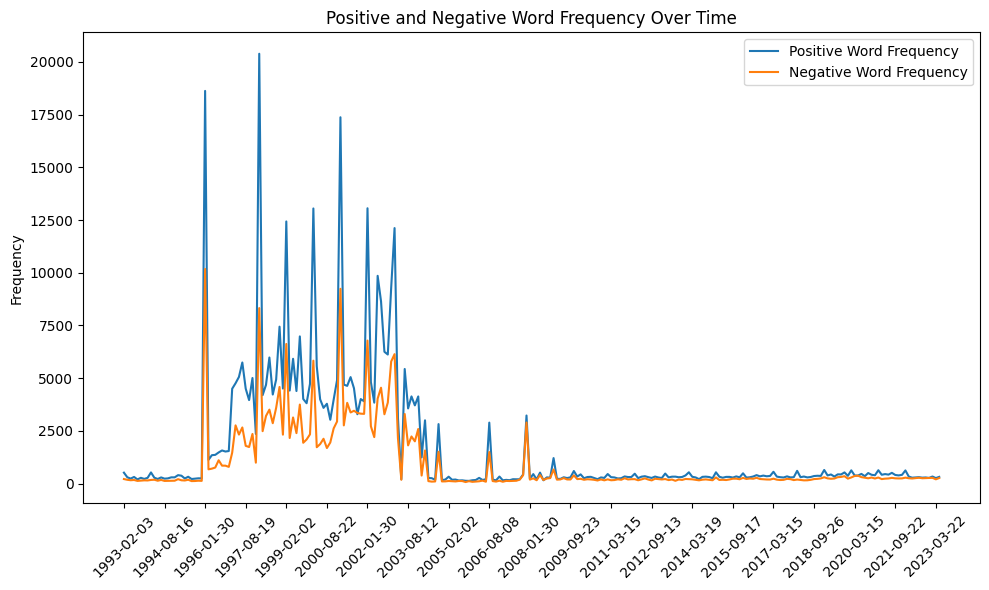

In [14]:
# Plotting the Positive Word Frequency and Negative Word Frequency
plt.figure(figsize=(10, 6))
plt.plot(dataset['Date'], dataset['Positive Word Frequency'], label='Positive Word Frequency')
plt.plot(dataset['Date'], dataset['Negative Word Frequency'], label='Negative Word Frequency')
plt.ylabel('Frequency')
plt.title('Positive and Negative Word Frequency Over Time')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Show only the 12th x-variable
x_ticks = dataset['Date'].iloc[::12]  # Select every 12th value
plt.xticks(x_ticks, rotation=45)

plt.tight_layout()  # Adjust the spacing of plot elements
plt.show()

###Run the same feature engineering and data augmentation from the above example

In [15]:
# Assuming your dataset is stored in a DataFrame called 'dataset'
column_names = dataset.columns

# Print all the column names
for column in column_names:
    print(column)

Federal_Reserve_Mins
Preprocessed Text
Date
Difference
Increase
Decrease
Level
CPI
Unemployment Rate
Consumer Sentiment
Retail Sales
Durable Goods Orders
Short-Term Treasury Bond Rate
Long-Term Treasury Bond Rate
Bank Reserves
Housing Sales
Nonfarm Payroll
LEI
CEI
LAG
Treasury Deposits
Average Hourly Earnings
Total Positive Sentiment
Total Negative Sentiment
Net Sentiment Score
Positive Word Frequency
Negative Word Frequency
Total Word Count
Proportion Positive Words
Proportion Negative Words


In [16]:
dataset['Short-Term Treasury Diff'] = dataset['Short-Term Treasury Bond Rate'].diff()
dataset['LEI_RollingMean'] = dataset['LEI'].rolling(window=3).mean()
dataset['CEI_RollingMean'] = dataset['CEI'].rolling(window=3).mean()
dataset['LAG_RollingMean'] = dataset['LAG'].rolling(window=3).mean()
dataset['Retail Sales_RollingMean'] = dataset['Retail Sales'].rolling(window=3).mean()
dataset['Durable Goods Orders_RollingMean'] = dataset['Durable Goods Orders'].rolling(window=3).mean()
# Shift up the rows in the specified columns
columns_to_shift = ['Total Positive Sentiment', 'Total Negative Sentiment','Net Sentiment Score', 'Positive Word Frequency', 'Negative Word Frequency', 'Total Word Count', 'Proportion Positive Words', 'Proportion Negative Words', 'Increase', 'Decrease']

for column in columns_to_shift:
    dataset.loc[:, column] = dataset[column].shift(-1)

# Remove the last row
dataset = dataset[:-1]

In [17]:
# Subset numerical columns
numerical_columns = dataset.select_dtypes(include='number')

# Remove 'Difference' from numerical columns
numerical_columns_subset = numerical_columns.drop('Difference', axis=1)

# Fill missing values with the mean in numerical columns
numerical_columns_subset.fillna(numerical_columns_subset.mean(), inplace=True)

# Define the dependent variable ('Difference')
y = dataset['Difference']

# Define the number of features to select
k = 15

# Perform univariate selection using f_regression
selector = SelectKBest(score_func=f_regression, k=k)
selected_features = selector.fit_transform(numerical_columns_subset, y)

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

# Get the selected feature names
selected_features_names = numerical_columns_subset.columns[selected_indices]

# Create a new dataframe with the selected features and 'Difference'
selected_dataset_lexicon = pd.concat([numerical_columns_subset[selected_features_names], y], axis=1)

# Get the feature scores
feature_scores = selector.scores_[selected_indices]

# Standardize the feature scores
scaler = StandardScaler()
standardized_scores = scaler.fit_transform(feature_scores.reshape(-1, 1))

# Print the selected features and their standardized relevance scores
print("Selected Features and Standardized Relevance Scores:")
for feature, score in zip(selected_features_names, standardized_scores):
    print(f"{feature}: {score[0]}")

Selected Features and Standardized Relevance Scores:
Increase: 0.14190543572865044
Decrease: -0.12707088218678597
Retail Sales: -0.3696987206194837
Durable Goods Orders: -0.3699671789448576
LEI: -0.3101232158551017
CEI: -0.2694696476225894
LAG: -0.2675747405268811
Total Negative Sentiment: -0.3825204362489746
Negative Word Frequency: -0.3504092264409003
Proportion Negative Words: -0.2854872863154195
Short-Term Treasury Diff: 3.711224398466407
LEI_RollingMean: -0.24984317097989842
CEI_RollingMean: -0.24955119977555995
LAG_RollingMean: -0.24666320702984837
Retail Sales_RollingMean: -0.3747509216487571


###Moving to further data augmentation, we can vectorize the processed text into a numerical representation. This gives a numerical representation in vector form to the unique list of words in the text. 

In [18]:
dataset = pd.read_csv(r'C:\Users\abact\BC-Project\data\dataset_adjusted.csv')

In [19]:
# Define the CountVectorizer object
count_vectorizer = CountVectorizer()

vectorized_text = count_vectorizer.fit_transform(dataset['Preprocessed Text'])

# Get the feature names from the count_vectorizer instance
feature_names = count_vectorizer.get_feature_names_out()

# Create a DataFrame from the vectorized text
vectorized_df = pd.DataFrame(vectorized_text.toarray(), columns=["vectorized_text_" + feature_name for feature_name in feature_names])

# Concatenate the vectorized DataFrame with the original dataset
merged_dataset = pd.concat([dataset, vectorized_df], axis=1)

# Print the merged dataset
print(merged_dataset)

                                  Federal_Reserve_Mins  \
0    A meeting of the Federal Open Market Committee...   
1    A meeting of the Federal Open Market Committee...   
2    A meeting of the Federal Open Market Committee...   
3    A meeting of the Federal Open Market Committee...   
4    A meeting of the Federal Open Market Committee...   
..                                                 ...   
234  The Federal Reserve, the central bank of the U...   
235  The Federal Reserve, the central bank of the U...   
236  The Federal Reserve, the central bank of the U...   
237  The Federal Reserve, the central bank of the U...   
238  The Federal Reserve, the central bank of the U...   

                                     Preprocessed Text        Date  \
0    meeting federal open market committee held off...  1993-05-18   
1    meeting federal open market committee held off...  1993-07-07   
2    meeting federal open market committee held off...  1993-08-17   
3    meeting federal op

###The positivity and negativity from the Loughran McDonald Master Dictionary can then be applied to these vectorized words, giving each vector its own sentiment score as well. Variables with no sentiment are taken out, as some of them are just words like 

In [20]:
sentiment_word_list = {}

with open(r"C:\Users\abact\BC-Project\data\external\Loughran-McDonald_MasterDictionary_1993-2021.csv", 'r') as file:
    # Skip the header line
    next(file)

    for line in file:
        # Split the line by comma
        values = line.strip().split(',')

        # Extract the necessary values
        word = values[0].lower()
        positive = float(values[8])  # Positive column index is 8
        negative = float(values[9])  # Negative column index is 9

        # Assign the word as positive or negative based on the positive or negative values
        if positive > 0:
            sentiment_word_list[word] = 1
        elif negative > 0:
            sentiment_word_list[word] = -1

# Remove 'vectorized_text_' prefix temporarily for searching sentiment words
prefix_len = len('vectorized_text_')

# Multiply sentiment values to the vectorized text columns
for column in merged_dataset.columns:
    if column.startswith('vectorized_text_'):  # Assuming vectorized text column names start with 'vectorized_text_'
        column_sentiment = column[prefix_len:]  # Extract the column sentiment name without the prefix
        column_sentiment = column_sentiment.lower()
        sentiment_value = sentiment_word_list.get(column_sentiment, 0)
        if sentiment_value == 1:
            merged_dataset[column] = merged_dataset[column] * 1  # Multiply by 1 for positive sentiment
        elif sentiment_value == -1:
            merged_dataset[column] = merged_dataset[column] * -1  # Multiply by -1 for negative sentiment
        else:
            merged_dataset[column] = merged_dataset[column] * 0  # Multiply by 0 for unknown sentiment
        
merged_dataset

,Federal_Reserve_Mins,Preprocessed Text,Date,Difference,Increase,Decrease,Level,CPI,Unemployment Rate,Consumer Sentiment,...,vectorized_text_zina,vectorized_text_zlate,vectorized_text_zobel,vectorized_text_zobel2,vectorized_text_zobel3,vectorized_text_zobel7,vectorized_text_zoebel1,vectorized_text_zone,vectorized_text_òscar,vectorized_text_şahin
0,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,1993-05-18,0.00,0.00,0.5,3.75,144.200,7.1,80.3,...,0,0,0,0,0,0,0,0,0,0
1,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,1993-07-07,-0.50,0.00,0.0,3.25,144.500,6.9,77.0,...,0,0,0,0,0,0,0,0,0,0
2,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,1993-08-17,0.00,0.00,0.0,3.25,144.800,6.8,77.3,...,0,0,0,0,0,0,0,0,0,0
3,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,1993-09-21,0.00,0.00,0.0,3.25,145.000,6.7,77.9,...,0,0,0,0,0,0,0,0,0,0
4,A meeting of the Federal Open Market Committee...,meeting federal open market committee held off...,1993-11-16,0.00,0.00,0.0,3.25,146.000,6.6,81.2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,"The Federal Reserve, the central bank of the U...",federal reserve central bank united state prov...,2022-09-21,0.75,0.75,0.0,3.25,296.539,3.5,58.6,...,0,0,0,0,0,0,0,0,0,0
235,"The Federal Reserve, the central bank of the U...",federal reserve central bank united state prov...,2022-11-02,0.75,0.50,0.0,4.00,297.987,3.7,59.9,...,0,0,0,0,0,0,0,0,0,0
236,"The Federal Reserve, the central bank of the U...",federal reserve central bank united state prov...,2022-12-14,0.50,0.25,0.0,4.50,298.990,3.5,59.7,...,0,0,0,0,0,0,0,0,0,0
237,"The Federal Reserve, the central bank of the U...",federal reserve central bank united state prov...,2023-02-01,0.25,0.25,0.0,4.75,300.536,3.4,64.9,...,0,0,0,0,0,0,0,0,0,0


###Running another univariate variable selection shows us the most important words and variables for mapping data with as varied data as possible.

In [21]:
# Subset numerical columns
numerical_columns = merged_dataset.select_dtypes(include='number')

# Remove 'Difference' from numerical columns
numerical_columns_subset = numerical_columns.drop('Difference', axis=1)

# Fill missing values with the mean in numerical columns
numerical_columns_subset.fillna(numerical_columns_subset.mean(), inplace=True)

# Fill missing values with the mean in 'Difference'
difference_mean = merged_dataset['Difference'].mean()
merged_dataset['Difference'].fillna(difference_mean, inplace=True)

# Define the number of features to select
k = 100

# Perform univariate selection using f_regression
selector = SelectKBest(score_func=f_regression, k=k)
selected_features = selector.fit_transform(numerical_columns_subset, merged_dataset['Difference'])

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

# Get the selected feature names
selected_features_names = numerical_columns_subset.columns[selected_indices]

# Create a new dataframe with the selected features and 'Difference'
selected_dataset = pd.concat([numerical_columns_subset[selected_features_names], merged_dataset['Difference']], axis=1)

# Get the feature scores
feature_scores = selector.scores_[selected_indices]

# Standardize the feature scores
scaler = StandardScaler()
standardized_scores = scaler.fit_transform(feature_scores.reshape(-1, 1))

# Print the selected features and their standardized relevance scores
print("Selected Features and Standardized Relevance Scores:")
for feature, score in zip(selected_features_names, standardized_scores):
    print(f"{feature}: {score[0]}")

Selected Features and Standardized Relevance Scores:
Increase: 1.1572515324431092
Decrease: 0.5088683215548543
Level: -0.2151107816819168
CPI: -0.1670615940104114
Unemployment Rate: -0.19054056796389438
Retail Sales: -0.07735618854473551
Durable Goods Orders: -0.07523765410725157
Short-Term Treasury Bond Rate: -0.19636509088431042
Long-Term Treasury Bond Rate: -0.21588667296728625
Bank Reserves: -0.18579058649813998
LEI: 0.07049076575471258
CEI: 0.16325331672266044
LAG: 0.16784714306293086
Treasury Deposits: -0.18969729369944954
Average Hourly Earnings: -0.17249282384144843
Net Sentiment Score: -0.10518597161261818
Positive Frequency: -0.1461717059740968
Negative Frequency: -0.1204732660920977
Word Count: -0.1314037099290642
Standardized Sentiment Score: -0.10518597161261803
Short-Term Treasury Diff: 9.789033861050529
LEI_RollingMean: 0.21032180189222607
CEI_RollingMean: 0.2110271602697947
LAG_RollingMean: 0.21800411572723555
Retail Sales_RollingMean: -0.09143525320667807
Durable Goods

In [22]:
selected_dataset

,Increase,Decrease,Level,CPI,Unemployment Rate,Retail Sales,Durable Goods Orders,Short-Term Treasury Bond Rate,Long-Term Treasury Bond Rate,Bank Reserves,...,vectorized_text_uncertainty,vectorized_text_unclear,vectorized_text_unexpected,vectorized_text_unknown,vectorized_text_unplanned,vectorized_text_upturn,vectorized_text_vary,vectorized_text_volatile,vectorized_text_volatility,Difference
0,0.00,0.5,3.75,144.200,7.1,160605.0,126529.0,2.93,6.04,5.646,...,-7,0,0,0,0,2,0,0,0,0.00
1,0.00,0.0,3.25,144.500,6.9,162816.0,128111.0,2.95,5.81,16.256,...,-4,0,0,0,0,2,0,0,0,-0.50
2,0.00,0.0,3.25,144.800,6.8,162506.0,129378.0,3.01,5.68,5.661,...,-1,0,0,0,0,0,0,0,0,0.00
3,0.00,0.0,3.25,145.000,6.7,163258.0,127233.0,2.95,5.36,5.117,...,-4,-1,-2,0,0,0,-1,-1,0,0.00
4,0.00,0.0,3.25,146.000,6.6,166594.0,130391.0,2.95,5.72,5.059,...,-5,0,0,0,0,0,0,-1,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,0.75,0.0,3.25,296.539,3.5,596156.0,275857.0,3.10,3.52,593.808,...,-5,0,0,0,0,0,0,-1,-2,0.75
235,0.50,0.0,4.00,297.987,3.7,601983.0,278512.0,3.99,3.98,634.548,...,-6,0,0,0,0,0,0,-1,-12,0.75
236,0.25,0.0,4.50,298.990,3.5,588540.0,281966.0,4.19,3.62,432.335,...,-5,0,-1,0,0,0,0,0,-5,0.50
237,0.25,0.0,4.75,300.536,3.4,603211.0,278372.0,4.57,3.53,491.848,...,-9,0,-2,0,0,0,0,-1,-2,0.25


###Spot check to make sure that positive-sounding words have positive values

In [23]:
unique_prosperity_values = selected_dataset['vectorized_text_risk'].unique()
print(unique_prosperity_values)

[  -3   -2    0   -4   -9   -1   -6   -8  -10  -13   -5 -259  -28  -39
  -33  -54  -58  -38  -44  -85 -174 -247 -171  -81 -137 -241 -103 -354
 -145 -146 -190 -255 -474 -393 -181 -291 -110 -195 -112 -419 -164  -80
 -119 -472 -214 -235 -175 -225 -326 -447 -700 -269 -432 -237 -346 -194
 -286 -311 -504 -239 -322 -409 -219 -412 -493  -84  -11 -468 -436 -341
 -312 -490  -24 -168 -172  -16   -7  -12 -161  -14  -18  -17  -45  -26
  -22  -32  -20  -27  -15  -19  -21  -23  -31  -35  -25  -37  -36  -40
  -34  -29  -30]


In [24]:
# Count the occurrences of 'prosperity'
total_count = selected_dataset['vectorized_text_risk'].sum()

# Print the total count
print(f"Total count of 'prosperity': {total_count}")

Total count of 'prosperity': -19252


###Perform univariate variable selection again to see if rolling means added any predictive power over previous variables

In [25]:
# Create a new dataset without the prefix
final_dataset = selected_dataset.rename(columns=lambda x: x.replace('vectorized_text_', ''))

# Print the column names of the new dataset
print(final_dataset.columns)

Index(['Increase', 'Decrease', 'Level', 'CPI', 'Unemployment Rate',
       'Retail Sales', 'Durable Goods Orders', 'Short-Term Treasury Bond Rate',
       'Long-Term Treasury Bond Rate', 'Bank Reserves',
       ...
       'uncertainty', 'unclear', 'unexpected', 'unknown', 'unplanned',
       'upturn', 'vary', 'volatile', 'volatility', 'Difference'],
      dtype='object', length=101)


In [26]:
selected_columns = final_dataset.columns[26:]

# Iterate over the selected columns
for column in selected_columns:
    # Get the unique values and their frequencies
    value_counts = final_dataset[column].value_counts()
    
    # Print the column name
    print(f"Column: {column}")
    
    # Print the unique values and frequencies
    for value, frequency in value_counts.items():
        print(f"Value: {value}, Frequency: {frequency}")
    
    print()  

Column: almost
Value: 0, Frequency: 157
Value: -1, Frequency: 41
Value: -2, Frequency: 18
Value: -3, Frequency: 10
Value: -40, Frequency: 1
Value: -38, Frequency: 1
Value: -15, Frequency: 1
Value: -33, Frequency: 1
Value: -50, Frequency: 1
Value: -31, Frequency: 1
Value: -12, Frequency: 1
Value: -11, Frequency: 1
Value: -24, Frequency: 1
Value: -47, Frequency: 1
Value: -26, Frequency: 1
Value: -8, Frequency: 1
Value: -4, Frequency: 1

Column: anticipated
Value: -5, Frequency: 26
Value: -6, Frequency: 20
Value: -4, Frequency: 18
Value: -8, Frequency: 17
Value: -2, Frequency: 14
Value: -10, Frequency: 14
Value: -7, Frequency: 14
Value: -3, Frequency: 14
Value: -9, Frequency: 12
Value: -12, Frequency: 5
Value: 0, Frequency: 4
Value: -11, Frequency: 4
Value: -1, Frequency: 4
Value: -13, Frequency: 3
Value: -18, Frequency: 3
Value: -53, Frequency: 3
Value: -56, Frequency: 3
Value: -132, Frequency: 2
Value: -136, Frequency: 2
Value: -37, Frequency: 2
Value: -39, Frequency: 2
Value: -139, Fre

In [27]:
columns_to_drop = ['hidden', 'enables', 'sporadic', 'unplanned']
final_dataset = final_dataset.drop(columns_to_drop, axis=1)

In [28]:
final_dataset['Date'] = dataset['Date']

In [32]:
# Split into training, validation, and test sets
train_data, val_test_data = train_test_split(final_dataset, test_size=0.2, shuffle=False)

# Split the combined set into validation and test sets
val_data, test_data = train_test_split(val_test_data, test_size=0.5, shuffle=False)

# Verify the sizes of each set
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

train_data.to_csv(r'C:\Users\abact\BC-Project\data\processed\train_data.csv', index=False)
test_data.to_csv(r'C:\Users\abact\BC-Project\data\processed\test_data.csv', index=False)
val_data.to_csv(r'C:\Users\abact\BC-Project\data\processed\val_data.csv', index=False)

Training set size: 191
Validation set size: 24
Test set size: 24


In [31]:
final_dataset

,Increase,Decrease,Level,CPI,Unemployment Rate,Retail Sales,Durable Goods Orders,Short-Term Treasury Bond Rate,Long-Term Treasury Bond Rate,Bank Reserves,...,uncertainty,unclear,unexpected,unknown,upturn,vary,volatile,volatility,Difference,Date
0,0.00,0.5,3.75,144.200,7.1,160605.0,126529.0,2.93,6.04,5.646,...,-7,0,0,0,2,0,0,0,0.00,1993-05-18
1,0.00,0.0,3.25,144.500,6.9,162816.0,128111.0,2.95,5.81,16.256,...,-4,0,0,0,2,0,0,0,-0.50,1993-07-07
2,0.00,0.0,3.25,144.800,6.8,162506.0,129378.0,3.01,5.68,5.661,...,-1,0,0,0,0,0,0,0,0.00,1993-08-17
3,0.00,0.0,3.25,145.000,6.7,163258.0,127233.0,2.95,5.36,5.117,...,-4,-1,-2,0,0,-1,-1,0,0.00,1993-09-21
4,0.00,0.0,3.25,146.000,6.6,166594.0,130391.0,2.95,5.72,5.059,...,-5,0,0,0,0,0,-1,0,0.00,1993-11-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,0.75,0.0,3.25,296.539,3.5,596156.0,275857.0,3.10,3.52,593.808,...,-5,0,0,0,0,0,-1,-2,0.75,2022-09-21
235,0.50,0.0,4.00,297.987,3.7,601983.0,278512.0,3.99,3.98,634.548,...,-6,0,0,0,0,0,-1,-12,0.75,2022-11-02
236,0.25,0.0,4.50,298.990,3.5,588540.0,281966.0,4.19,3.62,432.335,...,-5,0,-1,0,0,0,0,-5,0.50,2022-12-14
237,0.25,0.0,4.75,300.536,3.4,603211.0,278372.0,4.57,3.53,491.848,...,-9,0,-2,0,0,0,-1,-2,0.25,2023-02-01
